In [ ]:
!pip install torchwordemb
!pip install -U bcolz

  Created wheel for torchwordemb: filename=torchwordemb-0.0.9-cp36-cp36m-linux_x86_64.whl size=1787602 sha256=fe839cb9970afab05ff961bb342a11aeb6a86c06f650efc317c5e7e32c5a9b22
  Stored in directory: /root/.cache/pip/wheels/6a/e1/89/681d1be47271318455f36c2845f99cc33757dda3fc8b6731c7
Successfully built torchwordemb
     |████████████████████████████████| 1.5MB 3.4MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2656139 sha256=613b3b178b8e6f31f9c866679cc2cd3e515aee09da68359b8bb12d3c5e28f5a8
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


from IPython.display import clear_output 
clear_output()

Source Code for : Fact verification, Using pytorch, the architecture of the neural network is taken from "fact_iiith" paper  (see whatsapp group), INCOMPLETE ATM , CODE WILL NOT WORK ATM!

ARCHITECTURE THAT IS BEING IMPLEMENTED IS AS FOLLOW : 
![alt text](https://drive.google.com/uc?id=1FxQJc8wv8K2PtQSj_kkNMljI1nM_BnaR)

Both the claim & Evidence are passed through same embedding-layer, this provide us with D x N and D x M matrices. Note that D is the number of dimensions for each word. This value is 50 for glove dataset we used.

lets take up any 1 of these matrix and see how further operations are performed 

1. Each column in matrix represent an vector which is numerical representation of corresponding word in sentence
2. Each vector is of same size ( D ) 
3. We take these vectors 1 by 1 and pass them to LSTM Layer
4. Final output of LSTM is of size D (an array/vector of size D)
5. this output is merged with another output produced by different LSTM network using element wise multiplication

6. the final 1 X D output (or array of size D) is fed into a simple fully connected neural network which takes in input of size D and produces output of size 3 ( TRUE, FALSE, NOT ENOUGH INFO)

In [ ]:
# INITIAL SET-UP, SOME OF THE MODULES IMPORTED ARE NOT REQUIRED AND WILL BE REMOVED LATER ON 

import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import re #regular exp.
import string
import pickle
import gensim
import nltk

import torchtext as tt
import torchwordemb
import sys
import bcolz
from os import path

#pytorch modules (pytorch.org)
import torch
from torch.nn.modules import Module
from torch.nn import LSTM
from torch.nn import Embedding
from torch.nn import Sigmoid
from torch.nn import Dropout
from torch.utils.data import Dataset, DataLoader #an abstract class 

from string import punctuation # all possible punctuations, this is imported because we will be removing all punctuations from our sentences
punctuation = list(punctuation+ "-")
print(punctuation)
punctuation_map = dict()
for ch in punctuation:
  punctuation_map[ch]=0



['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '-']


Now that we are done importing modules, we will first implement a custom pytorch dataset class

DATASET LOADED
                                               claim  ... label
0  The Black Dahlia was only written by Hillary C...  ...     2
1  Dennis Hopper did not act in an American telev...  ...     1
2                   Bal Gangadhar Tilak was a judge.  ...     1
3  Luke Evans took a five-year acting hiatus from...  ...     1
4               Colin Quinn's middle name is Edward.  ...     0

[5 rows x 3 columns]
type of training_dataFrame <class 'pandas.core.frame.DataFrame'>
-------DATASET PREPROCESSING BEGINS--------
  >> datatype : 
claim       object
sentence    object
label        int64
dtype: object
total null (claim + sentence null): 0
distribution of output classes : (2761, 2847, 2804)


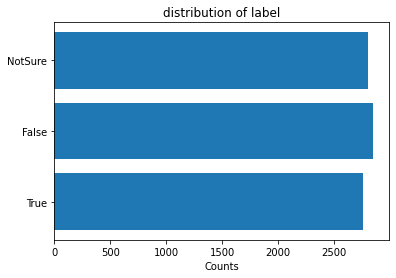

what is in db : bal gangadhar tilak was a judge 
actually its : bal gangadhar tilak was a judge 
international relations includes technology and engineering  economics  communication studies  history  international law  demography  philosophy  geography  social work  sociology  anthropology  criminology  psychology  gender studies  cultural studies  culturology  and diplomacy  globalization  diplomatic relations  state sovereignty  international security  ecological sustainability  nuclear proliferation  nationalism  economic development  global finance  as well as terrorism and organized crime  human security  foreign interventionism  and human rights  as well  as  more recently  comparative religion 
he has voiced joel in the last of us   booker dewitt in bioshock infinite   rhys in tales from the borderlands   delsin rowe in infamous second son   the joker in batman   arkham origins and batman   assault on arkham   talion in middle earth   shadow of mordor   kai leng in mass effect 

In [ ]:
#Create Custom Dataset (refer official doc @ https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) 

#Dataset will consist of 
    # 1. training_dataFrame (df) : this is dataframe where all data is stored in tabular format (3 columns)
    # 2. vocab_words (list of str) : list of all possible distinct words used
def getDistinctWordSet(userString):
  return set(userString.split(' '))

def removePunctuation(sent):
  for c in punctuation:
    if(c in sent):
      punctuation_map[c]+=1
      sent = sent.replace(c,' ')
  return sent

def print_punctuation_counts():
  for ch in punctuation_map:
    print(ch +" : "+str(punctuation_map[ch]))

def reset_punctuation_map():
  for ch in punctuation_map:
    punctuation_map[ch]=0

class FEVER_Dataset(Dataset):
  
  #OUTPUT LABEL LABEL MEANING
  # 0 => TRUE/positive
  # 1 => FALSE/negative
  # 2 => NEI (Not enough info)

  def __init__(self): #loads data

    try:
      data_temp = (pd.read_json('/content/drive/My Drive/Colab Notebooks/CLAIM_SENTENCE_LABEL.json'))
      print("DATASET LOADED")
    except:
      raise Exception("FEVER_DATASET ERROR : Cannot find claim_setence_label.json in content/")

    self.training_dataFrame = data_temp.loc[:,['claim', 'sentence', 'label']]

    print(self.training_dataFrame.head())
    print("type of training_dataFrame "+ str(type(self.training_dataFrame)))
    
    #--------------------------------------------------------------------------------------------------------
    
    print("-------DATASET PREPROCESSING BEGINS--------")    
    print("  >> datatype : \n"+str(self.training_dataFrame.dtypes)) #passed, datatype is good by default

    claim_null=0
    sentence_null=0
    for i in range(self.training_dataFrame.shape[0]):
      if not self[i]['claim']:
        claim_null+=1
      if not self[i]['sentence']:
        sentence_null+=1
    print("total null (claim + sentence null): " + str(claim_null+sentence_null)) #passed, no empty strings

    #output label distribution
    counter = ((self.training_dataFrame.label == 0).sum(), (self.training_dataFrame.label == 1).sum(), (self.training_dataFrame.label == 2).sum())
    print("distribution of output classes : " + str(counter))

    #plot graph
    fig, ax = plt.subplots()
    y_pos = np.arange(len(('True', 'False', 'NotSure')))
    ax.barh(y_pos, counter, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(('True', 'False', 'NotSure'))
    #ax.invert_yaxis()
    ax.set_xlabel('Counts')
    ax.set_title('distribution of label')
    plt.show()

    #convert everything to lowercase
    self.training_dataFrame.loc[:,['claim']] = self[:]['claim'].str.lower()
    self.training_dataFrame.loc[:,['sentence']]=self[:]['sentence'].str.lower()

    claim_with_punctuation=0
    sentence_with_punctuation=0
    
    #label sentences with punctuation
    temp_i=0
    for sent in self[:]['claim']:
      new_sent = removePunctuation(sent)
      if(new_sent != sent):
          claim_with_punctuation+=1
      self.training_dataFrame.loc[[temp_i],['claim']] = new_sent
      if(temp_i == 2):
        print('what is in db : '+str(self[temp_i]['claim']))
        print('actually its : ' +new_sent)
      temp_i+=1

    #print_punctuation_counts()
    reset_punctuation_map()

    #print("-----sentence----")
    temp_i=0
    for sent in self[:]['sentence']:
      new_sent = removePunctuation(sent)
      if(new_sent != sent):
        sentence_with_punctuation+=1
      self.training_dataFrame.loc[[temp_i],['sentence']] = new_sent 
      temp_i+=1
    
    #print("claim with punctuation (before) : "+str(claim_with_punctuation))
    #print("sentence with punctuation (before) : "+str(sentence_with_punctuation))  


    self.max_claim_length=0
    self.max_sentence_length=0
    c=''
    s=''
    #now both claim sentence are clean, therefore we will find maximum of each
    for sent in self[:]['claim']:
      if len(sent.split()) > self.max_claim_length:
        self.max_claim_length = len(sent.split())
        c = sent
  
    for sent in self[:]['sentence']:
      if len(sent.split()) > self.max_sentence_length:
        self.max_sentence_length = len(sent.split())
        s = sent
      
    print(c)
    print(s)   
    print("max claim length =  " + str(self.max_claim_length) + "and sent length = " + str(self.max_sentence_length))
  #---------------------------------------------------------------------------------------
  
  def getVocabSet(self):
    vocabSet = set()
    for i in range(self.training_dataFrame.shape[0]):
      c = self.getClaim(i)
      s = self.getSentence(i)
      vocabSet = vocabSet | getDistinctWordSet(c) | getDistinctWordSet(s)
    return vocabSet

  def __getitem__(self, index): #Please note that do not use the result obtained thru this method to update training_dataFrame, use self.training_dataFrame.loc 
    obj_dict = {}
    obj_dict['claim'] = self.training_dataFrame.loc[index]['claim']
    obj_dict['sentence'] = self.training_dataFrame.loc[index]['sentence']
    obj_dict['label'] = self.training_dataFrame.loc[index]['label']
    return obj_dict#self.training_dataFrame.loc[index]

  def __len__(self):
    return int(self.training_dataFrame.shape[0])

  def getClaim(self, index):
    obj = self[index]['claim']
    return obj

  def getSentence(self, index):
    obj = self[index]['sentence']
    return obj

  def getLabel(self, index):  
    return self[index]['label']

  def getData(self):
    return self.training_dataFrame
#end of class 

obj_dataset = FEVER_Dataset()

train_set, test_set = torch.utils.data.random_split(obj_dataset, [7000, 1412]) #split dataset

train_loader = DataLoader(train_set, batch_size = 64)
test_loader = DataLoader(test_set, batch_size = 64)

print("type : "+str(type(train_set)))
print("Number of distinct Words (vocab size): "+ str(len(obj_dataset.getVocabSet())))
print("Shape : " + str(obj_dataset.training_dataFrame.shape))

In [ ]:
for d in train_loader:
  c, s, l = d
  print(type(d['claim']))
  print(type(d['sentence']))
  print(type(d['label']))
  break 


<class 'list'>
<class 'list'>
<class 'torch.Tensor'>


In [ ]:
#LOAD TRAIN_SET AND TEST_SET from google drive
path_trainSet = "/content/drive/My Drive/Colab Notebooks/training_set"
path_testSet = "/content/drive/My Drive/Colab Notebooks/test_set"

with open(path_trainSet, 'rb') as f:
  train_set = pickle.load(f)

with open(path_testSet, 'rb') as f:
  test_set = pickle.load(f)


In [ ]:
#CHECKING DISTRIBUTION OF RECORDS IN TRAIN AND TEST SET 
distribution = [0, 0, 0]
for i in range(len(train_set)):
  distribution[train_set[i].label] += 1
print("STATISTICS FOR TRAIN_SET : " + str(distribution))
distribution = [0, 0, 0]
for i in range(len(test_set)):
  distribution[test_set[i].label] += 1
print("STATISTICS FOR TEST_SET : "+ str(distribution))  

type(train_set)

STATISTICS FOR TRAIN_SET : [2298, 2362, 2340]
STATISTICS FOR TEST_SET : [463, 485, 464]


torch.utils.data.dataset.Subset

In [ ]:
#SAVE TRAIN SET AND TEST-SET in google drive
with open(path_trainSet, 'wb') as f:
    pickle.dump(train_set, f)

with open(path_testSet, 'wb') as f:
    pickle.dump(test_set, f)

Before we move any further, we need to implement an embedding layer, since training embedding layer is going to be tough, im using pretrained embedding layer. The code mentioned below is taken from website as mentioned below

In [ ]:
#This class is responsible for setting up pre-trained embeddings, its constructor 
#accepts an input called embedding_type, 
#embedding_type = 0 => google news word2vec embedding 
#embedding_type = 1 => glove embedding

class PretrainedEmbeddingSetup:
  def __init__(self, embedding_type, already_executed_before=True): #0 => oogle news word2ve embedding, 1 => glove
    self.embedding_used = embedding_type
    if(embedding_type<0 or embedding_type>1):
      print("error, invalid embeding_type. Use 0 for word2vec and 1 for glove")
      return;
    
    self.path_to_read_raw_dataset = '/content/drive/My Drive/Colab Notebooks' 
    self.output_path = '/content/drive/My Drive/Colab Notebooks/parsedEmbeddingOutput'

    # gemsim KeyedVectors model ke bare mai yahan se dekhlo : https://radimrehurek.com/gensim/models/keyedvectors.html
    if(embedding_type==0): #prepare Google News word2vec
      print("preparing google-news word2vec embedding layer")
      
      if(already_executed_before == False):
        print('executing code first time : preparing embedding from scratch')

        #read binary file containg [word]-[vec] pair in each line
        GensimModel = gensim.models.KeyedVectors.load_word2vec_format(self.path_to_read_raw_dataset+'/GoogleNews-vectors-negative300.bin', binary=True)
      

        vectors = bcolz.carray(GensimModel.vectors, rootdir=f''+self.output_path+'/google_w2v.dat', mode='w')
       

        vectors = bcolz.carray(vectors[0:].reshape((-1, 300)), rootdir=f''+self.output_path+'/google_w2v.dat', mode='w')
        vectors.flush()

        self.word2idx = {}
        self.word2idx = {word: i for i, word in enumerate(GensimModel.index2word)}
         
        GensimModel=0 
        import gc
        gc.collect()

        with open(self.output_path+'/word2idx', 'wb') as f:
          pickle.dump(self.word2idx, f)
  
      else:
        self.word2idx = {}
        with open(self.output_path+'/word2idx', 'rb') as f:
          self.word2idx = pickle.load(f)
        print('loaded word2idx, type = '+str(type(self.word2idx)))

      #word2idx word 
      self.vectors = bcolz.open(f''+self.output_path+'/google_w2v.dat', mode='r')

      GensimModel=0 
      import gc
      gc.collect()  #forcing garbage collection to save up space occupied by gensimModel keyedVector model
      print("WORD2VEC EMBEDDING SUCCESSFULLY IMPORTED")

    else:
      print("preparing glove embedding layer")
      #Load pretrained embedding layer (ref : "medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76")
      words=[]
      word2idx={}
      #prepare ondisk container, initially we declare an array
      #this file will be written to specific location (output_glove_path) on disk
      vectors = bcolz.carray(np.zeros(1), rootdir=f''+self.output_path+'/6B.50.dat', mode='w')
      #Parse the glove file, which contains data in format <word> <array of size 50 containing learnt representn>
      #we will store all words in array word, and also store their index in word2idx array, 
      # we can use word2idx value to find corresponding vector associated with word in "vectors" array 
      idx = 0
      with open(f''+self.path_to_read_raw_dataset+'/glove.6B.50d.txt', 'rb') as f:
        for l in f: #extracting each line in file 
          line = l.decode().split() #break line based on " "
          word = line[0] #first,
          words.append(word)
          word2idx[word]=idx #map word to index , as it appear in the glove file 
          idx += 1
          vect = np.array(line[1:]).astype(np.float) #from index 1 till end, use these floating point nums. to build vector
          vectors.append(vect)

      #parsing is completed, write the result back into the file
      vectors = bcolz.carray(vectors[1:].reshape((-1, 50)), rootdir=f''+self.output_path+'/6B.50.dat', mode='w')
      vectors.flush()

      #pickle is inbuilt python lib. for serializing and deserializing python objects 

      #dump(obj, file) > Write the pickled representation of the object obj to the open file object file
      pickle.dump(words, open(f''+self.output_path+'/6B.50_words.pkl', 'wb')) #writing words data to disk
      pickle.dump(word2idx, open(f''+self.output_path+'/6B.50_idx.pkl', 'wb')) #writing index to disk

      #finally building embedding dictionary
      vectors = bcolz.open(f''+self.output_path+'/6B.50.dat')#[:]

      #picke.load() => Read the pickled representation of an object from the open file object file and return the reconstituted object hierarchy specified therein
      words = pickle.load(open(f''+self.output_path+'/6B.50_words.pkl', 'rb'))
      word2idx = pickle.load(open(f''+self.output_path+'/6B.50_idx.pkl', 'rb'))

      #glove maps word to its embedding vector, total number of words => 4,00,000
      self.glove = {w: vectors[word2idx[w]] for w in words} 
    
      #usage : glove['word']
      #print(glove['the'])
      print("GLOVE SUCCESSFULLY INITIALISED. USAGE : getVector(word)")

  def getEmbeddingVector(self, sampleWord):
    if(self.embedding_used==0):
      return self.vectors[self.word2idx[sampleWord]]
    else:
      return self.glove[sampleWord];

In [ ]:


#now we have embeddings for 400k words, lets build a function that will return a pre-trained embeddin layer
#an embedding layer takes input a number (index of word) and returns the vector associated with that number
def createEmbeddingLayer(weight_matrix, non_trainable=True):
  #this fxn should be called while building network
  weight_matrix = torch.Tensor(weight_matrix)
  num_embeddings, embedding_dim = weight_matrix.size()
  emb_layer = Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': weight_matrix})
  if non_trainable:
    emb_layer.weight.requires_grad = False
  
  return emb_layer, num_embeddings, embedding_dim 

#some quick notes for WEIGHT_MATRIX the shape is as follow
# Vocab_Size X Output_Dimension (ROWS X COLUMN) : INPUT DIMENSION
# Vocab_Size => count of all possible words expected
# Output_Dimension => 50 (we are producing embedding vector of len 50)

#How to get Vocab_Size ? 
# for each word in our training dataset , check if corresponding weight-vector exist in pretrained model
# if exist => use it 
# else initialize some random vector (ADDS TO ERROR IN ACCURACY)

#this function inputs 64 CLAIMS OR 64 SENTENCE, 
#input = batch_size x variable_list_size (basically 64 "str" types, 1 in each row and therefore total 64 rows)
#O/P FORMAT : (batch_size x fixed_padding_size)
def getBatchIndexTensor(net, batched_wordList, isClaim=True): #ip is array of string
  indexBatchlist=[]

  for text in batched_wordList:
    tokenList = text.split() #creates list of words / tokens
    paddedTokenTensor = getPaddedIndexTensor(net, tokenList, isClaim)
    indexBatchlist.append(paddedTokenTensor) 
  
  output_tensor = torch.stack(indexBatchlist)
  return output_tensor

#same as getIndexTensor except returns padded tensor
def getPaddedIndexTensor(net, wordList=[], isClaim=True):
  indexList = []
  for word in wordList:
    if word in net.word2index:
      indexList.append(int(net.word2index[word]))
    else:
      indexList.append(int(net.OOV_Index))
  
  #padd extra 0s
  if isClaim == True:
    zeroes_to_add = obj_dataset.max_claim_length - len(indexList)
    indexList.extend([0] * zeroes_to_add)

  elif isClaim == False:
    zeroes_to_add = obj_dataset.max_sentence_length - len(indexList)
    indexList.extend([0] * zeroes_to_add)

  #padded
  output = torch.tensor(indexList, dtype=torch.long)
  return output


#this function take input either 1 "claim" or 1 "sentence" in form of tokens (list)
def getIndexTensor(net, wordList=[]):
  indexList = []
  for word in wordList:
    if word in net.word2index:
      indexList.append(int(net.word2index[word]))
    else:
      indexList.append(int(net.OOV_Index))
  output = torch.tensor(indexList, dtype=torch.long)
  return output


#This class implements entire Neural Network, note that the objective atm is to implement a working prototype, Accuracy is ignored 
#at the moment, The network accepts 2 lists (claim & evidence) , each consisting of tokens however order of these tokens is preserved.  
# both these inputs are then passed through same embedding layer to convert them into numerical representation, the output of embedding layer 
# is a 2D Matrix (dimensions will be declared later when more concrete implementation is done)
# these two 2D Matrices are then fed to respective LSTM network, the output is merged (element-multiplication) 
# this merged output is finally passed through a general feedforward network which gives us the final output


# 1. Accept Claim and Evidence as input 
class Network(Module):
  def __init__(self, embedding_to_use):# if embedding_to_use is 0 it means we are going to use word2vec(best choice), if 1 => glove (not best)
    super(Network, self).__init__()
    print("Network Constructor called > loading pretrained embedding first")
    
    pretrained_embedding = PretrainedEmbeddingSetup(embedding_type=embedding_to_use)
    embedding_dimension = 0
    if(embedding_to_use == 0): #word2vec
      embedding_dimension = 300
    elif(embedding_to_use == 1): #
      embedding_dimension = 50

    #embed layer : CREATE WEIGHT MATRIX (PRETRAINED) 
    self.vocabSet = obj_dataset.getVocabSet() #get all words in our training dataset
    matrix_length = len(self.vocabSet)+1 #+1 because we are reserving 1 index for OOV 
    weight_matrix = np.zeros((matrix_length, embedding_dimension)) #init weight matrix that we will use
    word_found=0
    random_word_generated=0
    self.word2index ={} #this dictionary is what we will use to process input
    for i, word in enumerate(self.vocabSet):
      self.word2index[word]=i
      try:
        weight_matrix[i]=pretrained_embedding.getEmbeddingVector(word)
        word_found+=1
      except KeyError:
        random_word_generated+=1
        #print("not found : "+word)
        weight_matrix[i]=np.random.normal(scale=0.6, size=(embedding_dimension,))

    #average of all, note that last index of weight matrix returns embedding for OOV words (out of vocab)
    #this is just average of all vocab words (ref : https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g--6b-50d-txt)

    self.OOV_Index = weight_matrix.shape[0]-1;glove
    if(embedding_to_use == 0): #word2vec
      weight_matrix[self.OOV_Index] = np.zeros((300,));
    elif(embedding_to_use == 1):
      weight_matrix[self.OOV_Index] = [-0.12920076, -0.28866628, -0.01224866, -0.05676644, -0.20210965, -0.08389011, 0.33359843,  0.16045167,  0.03867431,  0.17833012,  0.04696583, -0.00285802, 0.29099807,  0.04613704, -0.20923874, -0.06613114, -0.06822549,  0.07665912, 0.3134014, 0.17848536, -0.1225775, -0.09916984, -0.07495987,  0.06413227, 0.14441176,  0.60894334,  0.17463093,  0.05335403, -0.01273871 , 0.03474107, -0.8123879 , -0.04688699,  0.20193407,  0.2031118 , -0.03935686,  0.06967544, -0.01553638 ,-0.03405238, -0.06528071 , 0.12250231,  0.13991883, -0.17446303, -0.08011883,  0.0849521,  -0.01041659, -0.13705009,  0.20127155,  0.10069408, 0.00653003,  0.01685157];
    else:
      print("ERROR")

    print(weight_matrix.shape)
    print("Total Words Matched with Pretrained Dataset : "+str(word_found))
    print("Total Words for which random Embedding generated : "+str(random_word_generated))
    
    #print("index of (the) : "+str(self.word2index['the']))
    #print('vector value as per weight matrix : ' + str(weight_matrix[self.word2index['the']]))
    #print('vector value as per glove ' + str(glove['the']))

    self.embedding, num_embeddings, embedding_dim = createEmbeddingLayer(weight_matrix, True)
    
    lstm_layers = 2
    lstm_hidden_size = 100
    #output and hidden size are same thing (STACKED , BIDIRECTIONAL LSTM) , i changd hidden_size to 100 from 10
    self.lstm_claim = LSTM(num_layers=lstm_layers, input_size=embedding_dimension, hidden_size=lstm_hidden_size, bidirectional=True)
    

    self.lstm_claim_denseNN = torch.nn.Sequential(
        torch.nn.Dropout(),
        torch.nn.Linear(lstm_layers*lstm_hidden_size, 100),
        torch.nn.Sigmoid()
    )
    
    self.lstm_evidence = LSTM(num_layers=lstm_layers, input_size=embedding_dimension, hidden_size=lstm_hidden_size, bidirectional=True)
    
    
    self.lstm_evidence_denseNN = torch.nn.Sequential(
        torch.nn.Dropout(),
        torch.nn.Linear(lstm_layers*lstm_hidden_size, 100),
        torch.nn.Sigmoid()
    )

    self.outputLayer = torch.nn.Sequential(
        torch.nn.Linear(100, 3), #Linear(inputshape, output shape)
        torch.nn.Sigmoid()
    )

  #use getIndexTensor(model, tokenList) to generate claimIndexTensor and sentenceIndexTensor during call to model
  def forward(self, claimIndexTensor, sentenceIndexTensor):

    #input shape to embedding : seq_length(padded) x batch_size(64)
    #output shape : seq_length(padded) X batch-size(64) X embedding_dimension(300)
    claimIndexTensor = torch.transpose(claimIndexTensor, 0, 1)
    sentenceIndexTensor = torch.transpose(sentenceIndexTensor, 0, 1)
    #print("   claim tensor shape : " + str(claimIndexTensor.shape))
    #print("   sentence tensor shape : " + str(sentenceIndexTensor.shape))
    
    outputClaim = self.embedding(claimIndexTensor)
    outputSentence = self.embedding(sentenceIndexTensor)
    
    #print("embedding output shape ")
    #print("   claim-tensor output : "+str(outputClaim.shape)) # N(seq-len) x 64(batch-size) x 300(embed-dimension)
    #print("   sentence-tensor output : " + str(outputSentence.shape)) # M x 64 x 300
    
    
    #outputClaim = torch.unsqueeze(outputClaim, 1)
    #outputSentence = torch.unsqueeze(outputSentence, 1)
    
    #input to lstm is of shape (seq_len, batch, input_size), seq_length = size of text, input_size = 300
    lstm_claimVec, lstm_claimForwardedPair = self.lstm_claim(outputClaim) #o/p shape for lstm_claimVec = [seq_len(N) X 64 X (2*hidden_size)]
    lstm_evidenceVec, lstm_evidenceForwardedPair = self.lstm_evidence(outputSentence) #o/p for lstm_evidenceVec = [seq_len(M) X 64 x (2*hidden_size)]
    #LSTM Output Shape :(seq_len, batch, num_directions * hidden_size)
    
    #IMPORTANT : 
    #Note that we are concerned with only last output of LSTM, and shape of that output is 2*hidden_size (or 200),
    #the last output exist at : [-1::], i.e, for last word of sequences, get output from each batch 

    #DROP AXIS AT POS 1 (pos 1 as in shape) 
    #lstm_claimVec = torch.squeeze(lstm_claimVec, 1)
    #lstm_evidenceVec = torch.squeeze(lstm_evidenceVec, 1)

    final_claim = self.lstm_claim_denseNN(lstm_claimVec[-1::])
    final_evidence = self.lstm_evidence_denseNN(lstm_evidenceVec[-1::])
    
    #print("claim-shape before multiplication : "+str(final_claim.shape))
    #print("evidence-shape before multiplication : "+str(final_evidence.shape))
    #element wise multiplication
    finalRepresentation = (final_claim)*(final_evidence) #finalRepresentation = #self.lstm_claim_denseNN(lstm_claimVec[-1])*self.lstm_evidence_denseNN(lstm_evidenceVec[-1])

    #print("shape of final multiplication result = " + str(finalRepresentation.shape))

    #print("input to FINAL LAYER HAS SHAPE : "+str(finalRepresentation.shape))
    finalOutput = self.outputLayer(finalRepresentation)
    #print("shape of final layer output = "  + str(finalOutput.shape))

    #finalOutput = finalOutput.reshape(1,3)
    #print("output shape : "+str(finalOutput.shape))
    return finalOutput


In [ ]:
#for training on gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = Network(embedding_to_use=0)

Network Constructor called > loading pretrained embedding first
preparing google-news word2vec embedding layer
loaded word2idx, type = <class 'dict'>
WORD2VEC EMBEDDING SUCCESSFULLY IMPORTED
(17530, 300)
Total Words Matched with Pretrained Dataset : 11592
Total Words for which random Embedding generated : 5937


In [ ]:
model.to(device)

Network(
  (embedding): Embedding(17530, 300)
  (lstm_claim): LSTM(300, 100, num_layers=2, bidirectional=True)
  (lstm_claim_denseNN): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Sigmoid()
  )
  (lstm_evidence): LSTM(300, 100, num_layers=2, bidirectional=True)
  (lstm_evidence_denseNN): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Sigmoid()
  )
  (outputLayer): Sequential(
    (0): Linear(in_features=100, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
#TRAINING AND EVALUATION OF MODEL : ALL VARIABLES INITIALISED HERE
import torch.optim as optim

LEARNING_RATE = 0.003
EPOCH=100

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
GOOGLE_COLAB_BUFFER_SIZE = 5 #how many messages to display on google-colab console 
bufferSizeCounter=0


In [ ]:
#IN CASE MODEL IS TRAINED BEFORE AND YOU NEED TO RESUME TRAINING 
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/savedModel"

ENTIRE_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/entire_model"

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model = torch.load(ENTIRE_MODEL_PATH)

In [ ]:
#a new input code for batches
#TRAIN THE MODEL
model.train()
creterion = torch.nn.CrossEntropyLoss() #CrossEntropyLoss automatically applies softmax, and so it takes input the raw_scores of each class
running_loss=0
LOSS_TRACKER=[]
for epoch in range(EPOCH):
  running_loss=0
  for current_batch, data_in_batch in enumerate(train_loader, 0):
    claims_inp = data_in_batch['claim'] #batch_size (64) X seq_size(variable)
    sentence_inp = data_in_batch['sentence'] #batch_size (64) x seq_size (variable)
    labels_inp = torch.tensor(data_in_batch['label'], dtype=torch.long).to(device)

    optimizer.zero_grad()
    
    #prepare inputs for model by converting string array of size batch
    claims_inp = getBatchIndexTensor(model, claims_inp, True).to(device)
    sentence_inp = getBatchIndexTensor(model, sentence_inp, False).to(device) 


    local_outputs = torch.squeeze(model(claims_inp, sentence_inp)) #actual output is : 1x64x3, changed to 64x3

    #print("in-training-loop : shape_of_model_output = "+str(local_outputs.shape)+" & shae of labels = "+str(labels_inp.shape));
    loss = creterion(local_outputs, labels_inp)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  #end of batch loop
  LOSS_TRACKER.append(running_loss)
  print(LOSS_TRACKER)

print(LOSS_TRACKER)

[94.193787753582, 94.22347891330719, 94.25284838676453, 94.20452880859375, 94.2359836101532, 94.26536387205124, 94.23885917663574, 94.21735173463821, 94.20355653762817, 94.22536432743073, 94.2202616930008, 94.21656733751297, 94.2406193614006, 94.18864440917969, 94.25550824403763, 94.21291434764862, 94.32234054803848, 94.19734007120132, 94.23383694887161, 94.22931629419327, 94.21582925319672, 94.20347374677658, 94.25822913646698, 94.21951311826706, 94.23303657770157, 94.23347336053848, 94.16266202926636, 94.20373177528381, 94.18827766180038, 94.19992816448212, 94.27244430780411, 94.24437153339386, 94.22920596599579, 94.2226254940033, 94.25469732284546, 94.28632140159607, 94.23774665594101, 94.21859729290009, 94.21949034929276, 94.20228791236877, 94.25990253686905, 94.21967965364456, 94.25402963161469, 94.2069839835167, 94.22948914766312, 94.19182777404785, 94.23440283536911, 94.22504150867462, 94.2057837843895, 94.21559154987335, 94.26019757986069, 94.24427020549774, 94.18940234184265, 

In [ ]:
#SAVE THE TRAINED MODEL
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/savedModel"
ENTIRE_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/entire_model"
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, MODEL_PATH) #overwrite to model_path

torch.save(model, ENTIRE_MODEL_PATH)

In [ ]:
#CLASSIFICATION ACCURACY MEASURE (NEW CODE)
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for data in test_loader:
    claims_inp = data['claim'] #batch_size (64) X seq_size(variable)
    sentence_inp = data['sentence'] #batch_size (64) x seq_size (variable)
    labels = torch.tensor(data['label'], dtype=torch.long).to(device) #64
    
    claims_inp = getBatchIndexTensor(model, claims_inp, True).to(device)
    sentence_inp = getBatchIndexTensor(model, sentence_inp, False).to(device)
    
    outputs = torch.squeeze(model(claims_inp, sentence_inp)) #outut shape : 64 x 3
    
    _, predicted = torch.max(outputs.data, 1)
    print("shape = "+str(outputs.shape))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print('Accuracy = '+str(100 * correct / total))

print('Accuracy = '+str(100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


shape = torch.Size([64, 3])
Accuracy = 70.3125
shape = torch.Size([64, 3])
Accuracy = 67.1875
shape = torch.Size([64, 3])
Accuracy = 68.22916666666667
shape = torch.Size([64, 3])
Accuracy = 69.53125
shape = torch.Size([64, 3])
Accuracy = 69.375
shape = torch.Size([64, 3])
Accuracy = 68.48958333333333
shape = torch.Size([64, 3])
Accuracy = 67.85714285714286
shape = torch.Size([64, 3])
Accuracy = 68.1640625
shape = torch.Size([64, 3])
Accuracy = 68.22916666666667
shape = torch.Size([64, 3])
Accuracy = 67.8125
shape = torch.Size([64, 3])
Accuracy = 68.03977272727273
shape = torch.Size([64, 3])
Accuracy = 66.40625
shape = torch.Size([64, 3])
Accuracy = 66.34615384615384
shape = torch.Size([64, 3])
Accuracy = 66.07142857142857
shape = torch.Size([64, 3])
Accuracy = 65.83333333333333
shape = torch.Size([64, 3])
Accuracy = 65.234375
shape = torch.Size([64, 3])
Accuracy = 65.25735294117646
shape = torch.Size([64, 3])
Accuracy = 65.01736111111111
shape = torch.Size([64, 3])
Accuracy = 64.967105